In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

class ThreeProductInventoryModel:
    def __init__(self, q1, q2, q3, d1, d2, d3, mu1, mu2, mu3, sigma1, sigma2, sigma3, T):
        self.q1, self.q2, self.q3 = q1, q2, q3
        self.d1, self.d2, self.d3 = d1, d2, d3
        self.mu1, self.mu2, self.mu3 = mu1, mu2, mu3
        self.sigma1, self.sigma2, self.sigma3 = sigma1, sigma2, sigma3
        self.T = T
        self.Y = 0
        # Расчет вспомогательных параметров
        self.a1 = d1 * q1
        self.a2 = d2 * q2
        self.a3 = d3 * q3
        self.Yz = self.a1 + self.a2 + self.a3

        self.b1 = d1 * mu1
        self.b2 = d2 * mu2
        self.b3 = d3 * mu3
        self.b = self.b1 + self.b2 + self.b3

        self.c1 = d1 * sigma1
        self.c2 = d2 * sigma2
        self.c3 = d3 * sigma3
        self.c = self.c1 + self.c2 + self.c3

    def calculate_k3_t3(self):
        denominator = (self.b + self.b3)
        t3 = (self.a3 / denominator) + ((self.c + self.c3)**2) / (2 * denominator**2)
        k3 = (self.b3 / denominator) + ((self.c + self.c3) * (self.b3*self.c - self.b*self.c3)) /
        (2 * self.a3 * denominator**2)
        return k3, t3

    def calculate_k2_t2(self, k3):
        numerator = self.a2 + self.a3 * (1 - k3)
        denominator = self.b + self.b2
        t2 = (numerator / denominator) + ((self.c + self.c2)**2) / (2 * denominator**2)
        k2 = (numerator / (self.a2 * denominator)) * self.b2 + \
             ((self.c + self.c2) * (self.b2*self.c - self.b*self.c2)) / (2 * self.a2 * denominator**2)
        return k2, t2

    def simulate_inventory(self, k2, k3, t2, t3, n_steps=150):
        time_points = np.linspace(0, self.T, n_steps)
        inventory1 = np.zeros_like(time_points)
        inventory2 = np.zeros_like(time_points)
        inventory3 = np.zeros_like(time_points)
        total_cost = np.zeros_like(time_points)

        # Начальные запасы
        inventory1[0] = self.q1
        inventory2[0] = k2 * self.q2
        inventory3[0] = k3 * self.q3
        total_cost[0] = self.a1 + self.a2 * k2 + self.a3 * k3
        self.Y = total_cost[0]
        for i in range(1, len(time_points)):
            t = time_points[i]
            dt = t - time_points[i-1]
            
            # Случайный спрос
            epsilon = np.random.normal(0, 1)
            dx1 = self.mu1 * dt + self.sigma1 * np.sqrt(dt) * epsilon
            dx2 = self.mu2 * dt + self.sigma2 * np.sqrt(dt) * epsilon
            dx3 = self.mu3 * dt + self.sigma3 * np.sqrt(dt) * epsilon
            
            inventory1[i] = max(inventory1[i-1] - dx1, 0)
            inventory2[i] = max(inventory2[i-1] - dx2, 0)
            inventory3[i] = max(inventory3[i-1] - dx3, 0)
            
            # Пополнение строго в t3 и t2
            if t >= t3 and time_points[i-1] < t3:
                inventory3[i] += (1 - k3) * self.q3
                total_cost[i] += (1 - k3) * self.a3
            
            if t >= t2 and time_points[i-1] < t2:
                inventory2[i] += (1 - k2) * self.q2
                total_cost[i] += (1 - k2) * self.a2
            
            total_cost[i] += total_cost[i-1]
        min1 = np.min(inventory1[:int(n_steps / 2)])
        min2 = np.min(inventory2[:int(n_steps /2)])
        min3 = np.min(inventory3[:int(n_steps / 2)])

       # print(f"\nМинимальные значения запасов:")
       # print(f"Ресурс 1: {min1:.2f} кг (достигает нуля: {'да' if min1 == 0 else 'нет'})")
        #print(f"Ресурс 2: {min2:.2f} кг (достигает нуля: {'да' if min2 == 0 else 'нет'})")
        #print(f"Ресурс 3: {min3:.2f} кг (достигает нуля: {'да' if min3 == 0 else 'нет'})")
        return time_points, inventory1, inventory2, inventory3, total_cost

    def run_simulation(self):
        k3, t3 = self.calculate_k3_t3()
        k2, t2 = self.calculate_k2_t2(k3)
        time_points, inv1, inv2, inv3, total_cost = self.simulate_inventory(k2, k3, t2, t3)
        print(k2)
        print(k3)
        # Создаем фигуру с двумя подграфиками вертикально
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        # График запасов (верхний)
        ax1.plot(time_points, inv1, label='Ресурс 1')
        ax1.plot(time_points, inv2, label='Ресурс 2')
        ax1.plot(time_points, inv3, label='Ресурс 3')
        ax1.axvline(x=t3, color='g', linestyle='--', label=f'Докупка 3 (день {t3:.0f})')
        ax1.axvline(x=t2, color='r', linestyle='--', label=f'Докупка 2 (день {t2:.0f})')
        ax1.set_xlabel('Дни')
        ax1.set_ylabel('Запасы (кг)')
        ax1.set_title('Динамика запасов')
        ax1.legend()
        ax1.grid(True)
        print(self.Yz)
        # График затрат (нижний)
        ax2.plot(time_points, total_cost, 'b-', label='Совокупные затраты')
        ax2.axhline(y=self.Y, color='r', linestyle='--', label=f'Начальная закупка: {self.Y/1e6:.2f}M')
        ax2.axhline(y=total_cost[-1], color='g', linestyle='--', label=f'Полная закупка: {total_cost[-1]/1e6:.2f}M')
        ax2.set_xlabel('Дни')
        ax2.set_ylabel('Затраты (ден.ед.)')
        ax2.set_title('Динамика затрат')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

        return {
            
            'k2': k2,
            'k3': k3,
            't2': t2,
            't3': t3,
            'Ym': self.a1 + self.a2 * k2 + self.a3 * k3,
            'Yz': self.Yz,
            'savings': (self.Yz - (self.a1 + self.a2 * k2 + self.a3 * k3)) / self.Yz * 100
        }

# Параметры модели
params = {
    'q1': 17900, 'q2': 58000, 'q3': 201915,
    'd1': 660.73, 'd2': 176.45, 'd3': 37.17,
    'mu1': 17900/30, 'mu2': 58000/30, 'mu3': 201915/30,
    'sigma1': 0.6*17900/30, 'sigma2': 0.4*58000/30, 'sigma3': 0.2*201915/30,
    'T': 30
}

# Запуск модели
model = ThreeProductInventoryModel(**params)
results = model.run_simulation()
print(f"Экономия: {results['savings']:.1f}%")

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 31)

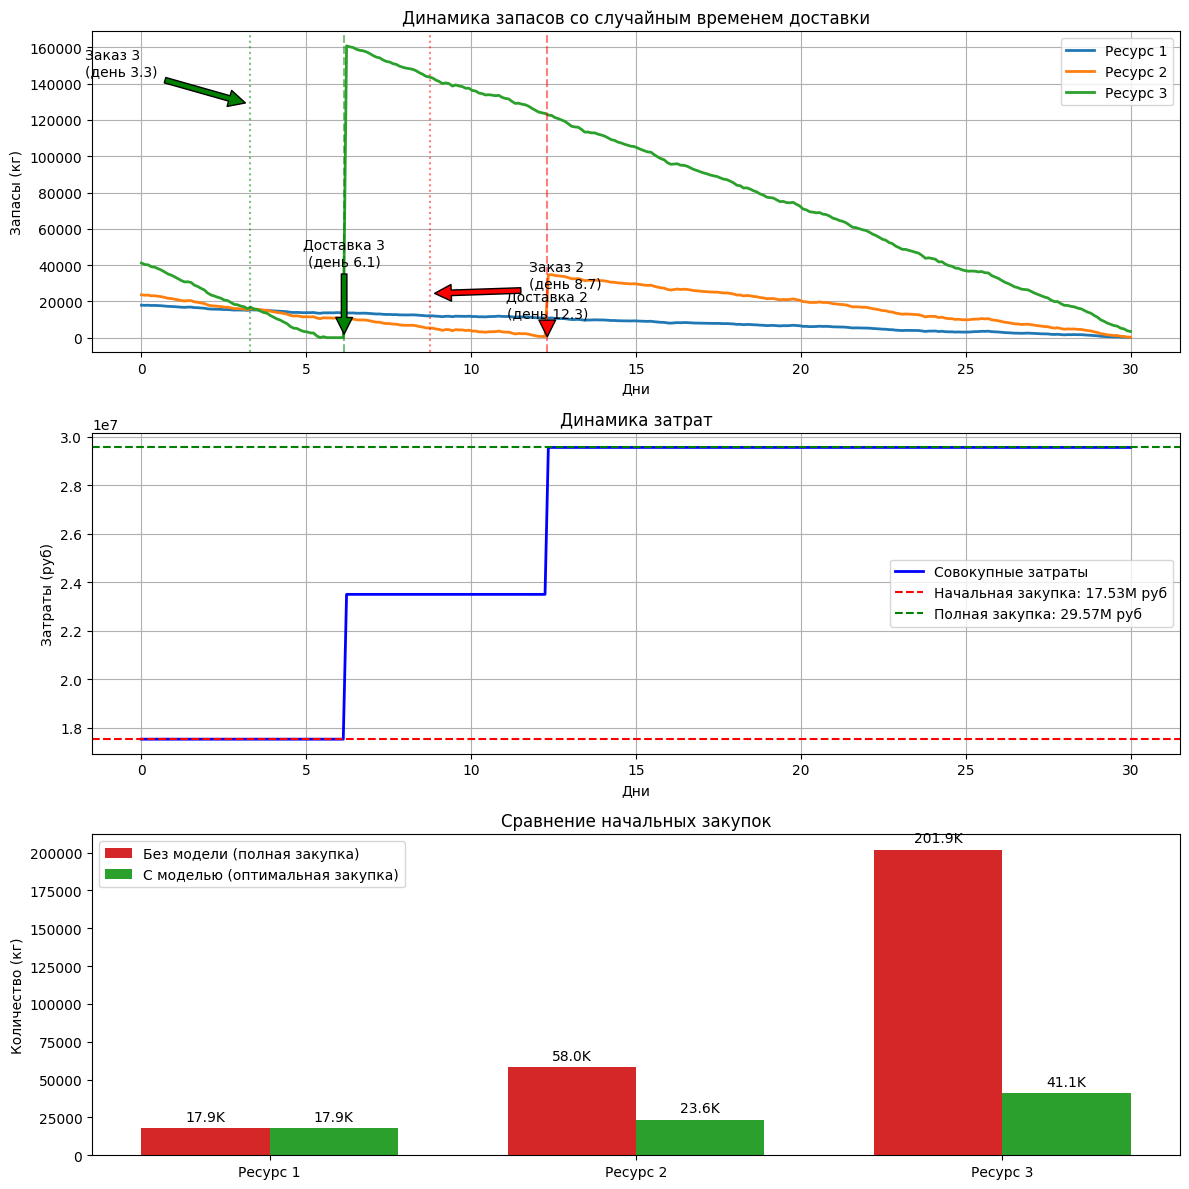


Результаты моделирования:
Экономия: 40.7%
Время доставки ресурса 2: 3.6 дней
Время доставки ресурса 3: 2.9 дней
Начальная закупка по модели: 17.53M руб
Полная закупка без модели: 29.57M руб


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon

class ThreeProductInventoryModel:
    def __init__(self, q1, q2, q3, d1, d2, d3, mu1, mu2, mu3, sigma1, sigma2, sigma3, T, lambda_delivery=0.1):
        self.q1, self.q2, self.q3 = q1, q2, q3
        self.d1, self.d2, self.d3 = d1, d2, d3
        self.mu1, self.mu2, self.mu3 = mu1, mu2, mu3
        self.sigma1, self.sigma2, self.sigma3 = sigma1, sigma2, sigma3
        self.T = T
        self.lambda_delivery = lambda_delivery  # Параметр экспоненциального распределения для времени доставки
        self.Y = 0
        
        # Расчет вспомогательных параметров
        self.a1 = d1 * q1
        self.a2 = d2 * q2
        self.a3 = d3 * q3
        self.Yz = self.a1 + self.a2 + self.a3

        self.b1 = d1 * mu1
        self.b2 = d2 * mu2
        self.b3 = d3 * mu3
        self.b = self.b1 + self.b2 + self.b3

        self.c1 = d1 * sigma1
        self.c2 = d2 * sigma2
        self.c3 = d3 * sigma3
        self.c = self.c1 + self.c2 + self.c3

    def calculate_k3_t3(self):
        denominator = (self.b + self.b3)
        t3 = (self.a3 / denominator) + ((self.c + self.c3)**2) / (2 * denominator**2)
        k3 = (self.b3 / denominator) + ((self.c + self.c3) * (self.b3*self.c - self.b*self.c3)) / (2 * self.a3 * denominator**2)
        return k3, t3

    def calculate_k2_t2(self, k3):
        numerator = self.a2 + self.a3 * (1 - k3)
        denominator = self.b + self.b2
        t2 = (numerator / denominator) + ((self.c + self.c2)**2) / (2 * denominator**2)
        k2 = (numerator / (self.a2 * denominator)) * self.b2 + \
             ((self.c + self.c2) * (self.b2*self.c - self.b*self.c2)) / (2 * self.a2 * denominator**2)
        return k2, t2

    def simulate_inventory(self, k2, k3, t2, t3, n_steps=300):
        time_points = np.linspace(0, self.T, n_steps)
        inventory1 = np.zeros_like(time_points)
        inventory2 = np.zeros_like(time_points)
        inventory3 = np.zeros_like(time_points)
        total_cost = np.zeros_like(time_points)
        
        # Время доставки для каждого ресурса (генерируется один раз)
        delivery_time3 = expon.rvs(scale=1/self.lambda_delivery)
        delivery_time2 = expon.rvs(scale=1/self.lambda_delivery)
        
        # Моменты заказа (должны быть заранее, чтобы доставка совпала с t2 и t3)
        order_time3 = max(0, t3 - delivery_time3)
        order_time2 = max(0, t2 - delivery_time2)
        
        # Начальные запасы
        inventory1[0] = self.q1
        inventory2[0] = k2 * self.q2
        inventory3[0] = k3 * self.q3
        total_cost[0] = self.a1 + self.a2 * k2 + self.a3 * k3
        self.Y = total_cost[0]
        
        # Флаги для отслеживания заказов и доставок
        order_placed3 = False
        order_placed2 = False
        delivered3 = False
        delivered2 = False
        
        for i in range(1, len(time_points)):
            t = time_points[i]
            dt = t - time_points[i-1]
            
            # Случайный спрос
            epsilon = np.random.normal(0, 1)
            dx1 = self.mu1 * dt + self.sigma1 * np.sqrt(dt) * epsilon
            dx2 = self.mu2 * dt + self.sigma2 * np.sqrt(dt) * epsilon
            dx3 = self.mu3 * dt + self.sigma3 * np.sqrt(dt) * epsilon
            
            inventory1[i] = max(inventory1[i-1] - dx1, 0)
            inventory2[i] = max(inventory2[i-1] - dx2, 0)
            inventory3[i] = max(inventory3[i-1] - dx3, 0)
            
            # Логика заказа и доставки для ресурса 3
            if not order_placed3 and t >= order_time3:
                order_placed3 = True
                # Можно добавить логирование или дополнительные действия при заказе
            
            if order_placed3 and not delivered3 and t >= t3:
                inventory3[i] += (1 - k3) * self.q3
                total_cost[i] += (1 - k3) * self.a3
                delivered3 = True
            
            # Логика заказа и доставки для ресурса 2
            if not order_placed2 and t >= order_time2:
                order_placed2 = True
            
            if order_placed2 and not delivered2 and t >= t2:
                inventory2[i] += (1 - k2) * self.q2
                total_cost[i] += (1 - k2) * self.a2
                delivered2 = True
            
            total_cost[i] += total_cost[i-1]
        
        return time_points, inventory1, inventory2, inventory3, total_cost, order_time2, order_time3
    def run_simulation(self):
        k3, t3 = self.calculate_k3_t3()
        k2, t2 = self.calculate_k2_t2(k3)
        time_points, inv1, inv2, inv3, total_cost, order_time2, order_time3 = self.simulate_inventory(k2, k3, t2, t3)
        
        # Создаем фигуру с тремя графиками
        fig = plt.figure(figsize=(12, 12))
        gs = fig.add_gridspec(3, 1)
        ax1 = fig.add_subplot(gs[0, 0])  # График запасов
        ax2 = fig.add_subplot(gs[1, 0])  # График затрат
        ax3 = fig.add_subplot(gs[2, 0])  # Гистограмма сравнения
        
        # 1. График запасов с аннотациями
        ax1.plot(time_points, inv1, label='Ресурс 1', linewidth=2)
        ax1.plot(time_points, inv2, label='Ресурс 2', linewidth=2)
        ax1.plot(time_points, inv3, label='Ресурс 3', linewidth=2)
        
        # Аннотации для ресурса 3 (зеленый)
        ax1.axvline(x=t3, color='green', linestyle='--', alpha=0.5)
        ax1.annotate(f'Доставка 3\n(день {t3:.1f})', 
                     xy=(t3, 0), xytext=(t3, max(inv3)/4),
                     arrowprops=dict(facecolor='green', shrink=0.05),
                     horizontalalignment='center')
        
        ax1.axvline(x=order_time3, color='green', linestyle=':', alpha=0.5)
        ax1.annotate(f'Заказ 3\n(день {order_time3:.1f})', 
                     xy=(order_time3, max(inv3)*0.8), 
                     xytext=(order_time3-5, max(inv3)*0.9),
                     arrowprops=dict(facecolor='green', shrink=0.05))
        
        # Аннотации для ресурса 2 (красный)
        ax1.axvline(x=t2, color='red', linestyle='--', alpha=0.5)
        ax1.annotate(f'Доставка 2\n(день {t2:.1f})', 
                     xy=(t2, 0), xytext=(t2, max(inv2)/3),
                     arrowprops=dict(facecolor='red', shrink=0.05),
                     horizontalalignment='center')
        
        ax1.axvline(x=order_time2, color='red', linestyle=':', alpha=0.5)
        ax1.annotate(f'Заказ 2\n(день {order_time2:.1f})', 
                     xy=(order_time2, max(inv2)*0.7), 
                     xytext=(order_time2+3, max(inv2)*0.8),
                     arrowprops=dict(facecolor='red', shrink=0.05))
        
        ax1.set_xlabel('Дни')
        ax1.set_ylabel('Запасы (кг)')
        ax1.set_title('Динамика запасов со случайным временем доставки')
        ax1.legend()
        ax1.grid(True)
        
        # 2. График затрат
        ax2.plot(time_points, total_cost, 'b-', label='Совокупные затраты', linewidth=2)
        ax2.axhline(y=self.Y, color='r', linestyle='--', label=f'Начальная закупка: {self.Y/1e6:.2f}M руб')
        ax2.axhline(y=total_cost[-1], color='g', linestyle='--', label=f'Полная закупка: {total_cost[-1]/1e6:.2f}M руб')
        ax2.set_xlabel('Дни')
        ax2.set_ylabel('Затраты (руб)')
        ax2.set_title('Динамика затрат')
        ax2.legend()
        ax2.grid(True)
        
        # 3. Гистограмма сравнения начальных закупок
        products = ['Ресурс 1', 'Ресурс 2', 'Ресурс 3']
        without_model = [self.q1, self.q2, self.q3]  # Полная закупка без модели
        with_model = [self.q1, k2*self.q2, k3*self.q3]  # Закупка по модели
        
        x = np.arange(len(products))
        width = 0.35
        
        rects1 = ax3.bar(x - width/2, without_model, width, label='Без модели (полная закупка)', color='tab:red')
        rects2 = ax3.bar(x + width/2, with_model, width, label='С моделью (оптимальная закупка)', color='tab:green')
        
        ax3.set_ylabel('Количество (кг)')
        ax3.set_title('Сравнение начальных закупок')
        ax3.set_xticks(x)
        ax3.set_xticklabels(products)
        ax3.legend()
        
        # Добавляем подписи значений
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax3.annotate(f'{height/1000:.1f}K',
                             xy=(rect.get_x() + rect.get_width() / 2, height),
                             xytext=(0, 3),  # 3 points vertical offset
                             textcoords="offset points",
                             ha='center', va='bottom')
        
        autolabel(rects1)
        autolabel(rects2)
        
        plt.tight_layout()
        plt.show()

        return {
            'k2': k2,
            'k3': k3,
            't2': t2,
            't3': t3,
            'order_time2': order_time2,
            'order_time3': order_time3,
            'delivery_time2': t2 - order_time2,
            'delivery_time3': t3 - order_time3,
            'Ym': self.a1 + self.a2 * k2 + self.a3 * k3,
            'Yz': self.Yz,
            'savings': (self.Yz - (self.a1 + self.a2 * k2 + self.a3 * k3)) / self.Yz * 100
        }

# Параметры модели и запуск (остается без изменений)
params = {
    'q1': 17900, 'q2': 58000, 'q3': 201915,
    'd1': 660.73, 'd2': 176.45, 'd3': 37.17,
    'mu1': 17900/30, 'mu2': 58000/30, 'mu3': 201915/30,
    'sigma1': 0.6*17900/30, 'sigma2': 0.4*58000/30, 'sigma3': 0.2*201915/30,
    'T': 30,
    'lambda_delivery': 0.2
}

model = ThreeProductInventoryModel(**params)
results = model.run_simulation()

print(f"\nРезультаты моделирования:")
print(f"Экономия: {results['savings']:.1f}%")
print(f"Время доставки ресурса 2: {results['delivery_time2']:.1f} дней")
print(f"Время доставки ресурса 3: {results['delivery_time3']:.1f} дней")
print(f"Начальная закупка по модели: {results['Ym']/1e6:.2f}M руб")
print(f"Полная закупка без модели: {results['Yz']/1e6:.2f}M руб")